### Example 4: Wavelength-dependent Complex Refractive Index 

This example shows how to calculate BLS spectra for particles with a wavelength-dependent complex refractive index. Here, we will use the Lorentzian oscillator model outlined by Bain and Preston (DOI:10.1063/1.5082157). Again, users shouldn't worry too much about how the refractive index is described: the code is agnostic to this. All that is required is that your chosen description of the refractive index produces an array of complex numbers the same length as the array of wavelengths. This situation of having an unchanging complex refractive index is somewhat unusual in aerosol science, although it does apply to the dyed polystyrene spheres in the referenced paper. However, as demonstrated by examples 2 and 3, this is easily extended to mroe realistic situations where the complex RI varies with particle size as well as wavelength.

### Import Necessary Packages

Imports the packages needed to perform calculations. All are standard packages and should be a part of any IDE, aside from BLSfunctions which should be downloaded along with this Notebook and placed in the same folder.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import BLSfunctions as BLS
import time

### Set Parameters for Calculation

Set parameter ranges to be used in calculation. As written, the units for radius and wavelength are in microns. This is not necessary but you should use the same units for both. The refractive index is set to be constant across the wavelength range as detailed above. Details of the experimental geometry can be found in this paper [insert doi] to guide users in how to choose $\theta_i$ and $\varphi_i$ for their desired experimental geometry. 

In [21]:
wl = np.linspace(0.4, 0.8, 1201) #wavelength range and resolution
r = np.linspace(1.0,3.0,21) #radii to use in calculations
theta_i = np.pi/2 #incident light theta
phi_i = np.pi/2 #incident light phi
NA = 0.5 #numerical aperture of collection lens

### Calculate Refractive Index

Use the Lorentzian oscillator model to calculate the complex RI as a function of wavelength. As emphasised above, there is nothing special about this particular method, users may describe the complex RI however they like. The only requirement for the code to run is that you produce an array of complex RI values the same size as the input wavelength array. Oscillator parameters chosen to match Fig. 4 of doi.org/10.1063/1.5082157. 

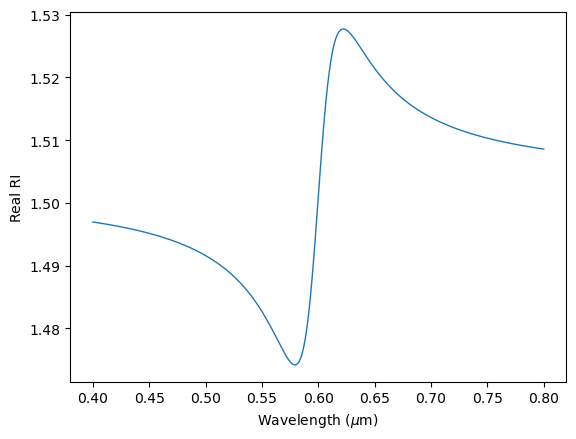

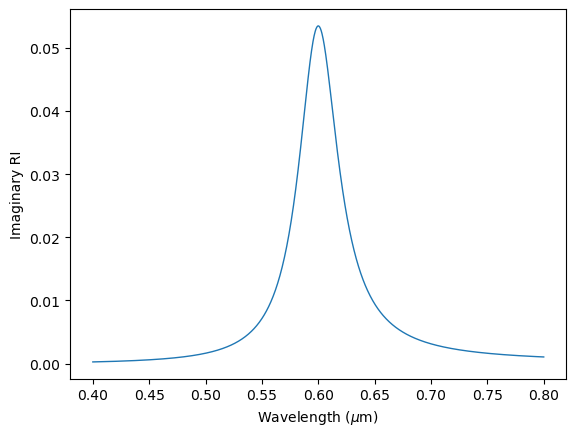

In [22]:
A = 0.01 #amplitude of Lorentzian oscillator
nu0 = 1/0.6 #central frequency of oscillator
gamma = 0.119 #FWHM of oscillator
ninf = 1.5 #refracitve index at infinite wavenumber
nu = 1/wl #convert wavelength to wavenumber
n = ninf + (2/np.pi)*(((A*nu0)*((nu0**2) - (nu**2) + ((gamma**2)/4)))/((((nu0**2) - (nu**2) + ((gamma**2)/4))**2) + ((nu*gamma)**2)))
k = (A/np.pi)*((0.5*gamma/(((nu-nu0)**2)+((gamma**2)/4)))-(0.5*gamma/(((nu+nu0)**2)+((gamma**2)/4))))
m = n + 1j*k
plt.plot(wl, np.real(m), linewidth=1)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Real RI')
plt.show()
plt.plot(wl, np.imag(m), linewidth=1)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Imaginary RI')
plt.show()

### Calculate Spectra

Calculates spectra using the parameters set above. Full details of the algorithm, along with the rationale behind the order of various steps, choices of number of angular grid points, and the choice of the trapezoidal rule, can be found in this paper [insert doi]. A brief outline of the steps is as follows:
- Calculate incident wavevector and size parameters from input variables
- Find Wiscombe limit for each size parameter
- Calculate number of grid points to use for each radius (and ensure these are even)
- Calculate prefactors for each value of n needed
- Loop over radius values
    * Calculate scattering coefficients up to Wiscombe limit for each size parameter
    * Calculate scattered wavevectors and angular functions with necessary number of grid points up to Wiscombe limit
    * Loop over wavelengths
        + Calculate $S_1, S_2$ by performing necessary summations 
        + Calculate $S_{11}$ for each angular grid point
        + Integrate $S_{11}$ using the trapezoidal rule to get scattered intensity at chosen wavelength

In [23]:
wn = (2*np.pi)/wl #wavenumber of incident light
vi = np.transpose(np.array([np.sin(theta_i)*np.cos(phi_i), np.sin(theta_i)*np.sin(phi_i), np.cos(theta_i)])) #incident wavevector
x = np.zeros((np.size(r), len(wl))) #space for size parameters
for i0, ri in enumerate(r):
    x[i0,:] = (2*np.pi*ri)/wl #calculate size parameters for each radius
omax = np.round(x + (4*(x**(1/3))) + 2).astype(int) #maximum order to which sums need to be evaluated for each size parameter
o = np.linspace(1, np.max(omax), np.max(omax)) #list of orders used to calculate prefactors, coefficients and angular functions
omaxr = np.max(omax, axis=1) #maximum order required in summation for each radius
npts = np.round((0.75*NA*omaxr)) + 18 #number of pts to use for numerical integration
odd = np.mod(npts, 2) == 1 #find odd grid points
npts[odd] += 1 #make odd grid points even
pf = ((2*o)+1)/(o*(o+1)) #prefactors for eventual sum
spectra = np.zeros_like(x) #space for scattering spectra
for i0 in range(len(r)):
    lstart = time.time()
    an = np.zeros((len(o), len(wl)), dtype=complex)
    bn = np.zeros_like(an) #space for coefficients for given radius
    for i1 in range(omaxr[i0]):
        an[i1,:] = pf[i1]*BLS.Mie_an(int(o[i1]), m, x[i0,:])
        bn[i1,:] = pf[i1]*BLS.Mie_bn(int(o[i1]), m, x[i0,:]) #calculate given order of coefficients multiplied by prefactor
    theta_s = np.linspace(0, np.arcsin(NA), int(npts[i0]))#range of scattered theta to look at (angle between scattered wavevector and detector axis)
    phi_s = np.linspace(0, 2*np.pi, int(npts[i0])) #range of scattered phi to use (angle between scattered wavevector and x-axis)
    theta_c = np.zeros((len(theta_s), len(phi_s)))
    for i1 in range(len(theta_s)):
        for i2 in range(len(phi_s)):
            vs = np.transpose(np.array([np.sin(theta_s[i1])*np.cos(phi_s[i2]), np.sin(theta_s[i1])*np.sin(phi_s[i2]), np.cos(theta_s[i1])])) #scattering vector components (minus k, which is not needed for collection angle calculation)
            theta_c[i1,i2] = np.arccos(np.dot(vi,vs)) #collection angle for scattered wavevector
    pin = np.zeros((len(theta_s), len(phi_s), omaxr[i0]))
    taun = np.zeros_like(pin) #space for values of pi_n and tau_n (independent of size parameter except for summation maximum, so can be evaluated before loop and called on later)
    for i1 in range(len(theta_s)):
        pn = BLS.Mie_pin(omaxr[i0], theta_c[i1,:])
        tn = BLS.Mie_taun(omaxr[i0], theta_c[i1,:]) #calculate necessary range of pi_n and tau_n across collection angle range
        pin[i1,:,:] = np.transpose(pn)
        taun[i1,:,:] = np.transpose(tn) #put into matrices
    spectrum = np.zeros_like(wl) #space for spectrum at given radius
    for i1 in range(len(wl)):
        S1 = complex(0,0)
        S2 = complex(0,0) #initial values for summation
        for i2 in range(omax[i0,i1]):
            S1 += (an[i2,i1]*pin[:,:,i2]) + (bn[i2,i1]*taun[:,:,i2])
            S2 += (an[i2,i1]*taun[:,:,i2]) + (bn[i2,i1]*pin[:,:,i2]) #calculate summation terms
        S11 = (1/(2*(wn[i1]**2)))*((np.abs(S2)**2) + (np.abs(S1)**2)) #calculate S11 as function of theta and phi
        theta_int_terms = np.zeros_like(S11)
        for i2 in range(len(phi_s)):
            theta_int_terms[:,i2] = np.sin(theta_s)*S11[:,i2] #calculate terms for theta integration (multiply S11 terms by sin(theta))
        phi_int_terms = ((theta_s[1] - theta_s[0])/2)*(theta_int_terms[0,:] + theta_int_terms[-1,:] + 2*np.einsum('ij->j',theta_int_terms[1:-1,:])) #perform theta integration using Simpson's 1/3 rule for regular spaced points
        spectrum[i1] = ((phi_s[1] - phi_s[0])/2)*(phi_int_terms[0] + phi_int_terms[-1] + 2*np.einsum('i->', phi_int_terms[1:-1])) #perform phi integration using Simpson's 1/3 rule and put into vector
    spectra[i0,:] = spectrum #put spectrum into matrix
    print("Spectrum", str(i0+1), "of", str(len(r)), "complete in", time.time()-lstart, "s.")

Spectrum 1 of 21 complete in 0.9463174343109131 s.
Spectrum 2 of 21 complete in 1.039372444152832 s.
Spectrum 3 of 21 complete in 1.109544277191162 s.
Spectrum 4 of 21 complete in 1.138613224029541 s.
Spectrum 5 of 21 complete in 1.2313835620880127 s.
Spectrum 6 of 21 complete in 1.2891006469726562 s.
Spectrum 7 of 21 complete in 1.4757227897644043 s.
Spectrum 8 of 21 complete in 1.4903793334960938 s.
Spectrum 9 of 21 complete in 1.5138978958129883 s.
Spectrum 10 of 21 complete in 1.6163408756256104 s.
Spectrum 11 of 21 complete in 1.6706295013427734 s.
Spectrum 12 of 21 complete in 1.7797894477844238 s.
Spectrum 13 of 21 complete in 1.849806308746338 s.
Spectrum 14 of 21 complete in 1.9328334331512451 s.
Spectrum 15 of 21 complete in 2.0173890590667725 s.
Spectrum 16 of 21 complete in 2.1553549766540527 s.
Spectrum 17 of 21 complete in 2.178030014038086 s.
Spectrum 18 of 21 complete in 2.2316083908081055 s.
Spectrum 19 of 21 complete in 2.2999658584594727 s.
Spectrum 20 of 21 complete

### Plots

Plots spectra as function of wavelength and radius.

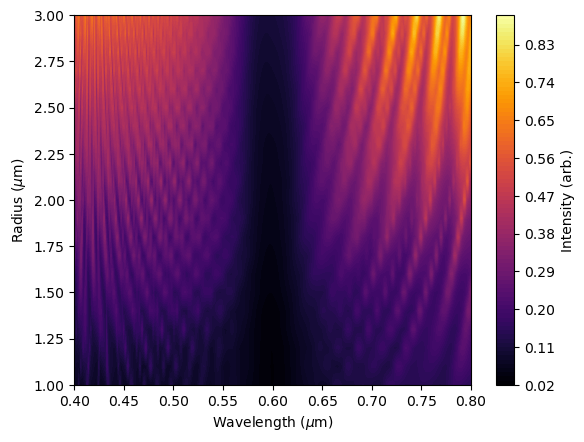

In [24]:
plt.contourf(wl, r, spectra, 100, cmap='inferno')
plt.colorbar(label='Intensity (arb.)')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Radius ($\mu$m)')
plt.show()